In [2]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import scale
import time
from scipy.interpolate import interp1d
from scipy.signal import resample
import seaborn as sns

In [41]:
# functions
def segment_resample(data:pd.DataFrame, session:str, n_pitch:int, del_df:list) -> pd.DataFrame:
    # get data by session for a pitcher
    df_by_pitch = data[data["session_pitch"] == session].reset_index()

    # segment from foot contact to ball release
    fc_time = df_by_pitch["fp_10_time"].unique()
    fc_inx = df_by_pitch[df_by_pitch["time"] == fc_time[0]].index

    br_time = df_by_pitch["BR_time"].unique()
    br_inx = df_by_pitch[df_by_pitch["time"] == br_time[0]].index

    # delet frame if aplicable
    if fc_inx.empty:
        print(f"{id}: trial {n_pitch + 1} invalid trial: foot contact not defined")
        del_df.append(n_pitch)
        return df_by_pitch
    elif br_inx.empty:
        print(f"{id}: trial {n_pitch + 1} invalid trial: ball release not defined")
        del_df.append(n_pitch)
        return df_by_pitch
    elif fc_inx > br_inx:
        print(f"{id}: trial {n_pitch + 1} invalid trial: the order of events error (ball release to foot contact)")
        del_df.append(n_pitch)
        return df_by_pitch

    # segment data form fc to br
    segmented_df = df_by_pitch[fc_inx[0]:br_inx[0]].copy()

    # fill nan
    segmented_df.ffill().bfill()

    # get columns name
    current_colmuns = segmented_df.columns

    # resample it to 101 data points
    resampled_segmented_data = pd.DataFrame(resample(segmented_df, 101),
                                                columns=current_colmuns)

    # fill nan if exists
    #resampled_segmented_data = resampled_segmented_data.fillna(method='bfill')
    resampled_segmented_data.drop(columns=["index",
                                            "session_pitch",
                                            "time",
                                            "pkh_time",
                                            "fp_10_time",
                                            "fp_100_time",
                                            "MER_time",
                                            "MIR_time",
                                            "BR_time"], inplace=True)



    return resampled_segmented_data



    

### Data set

In [4]:
# absolute path to the data
path = "/home/yyanagita/data/motion_classification/joint_velos.csv"

# import data to pandas data frame
df_joint_velocity = pd.read_csv(path)

In [5]:
# display first 10 rows
df_joint_velocity.head(10)

,session_pitch,time,elbow_velo_x,elbow_velo_y,elbow_velo_z,rear_hip_velo_x,rear_hip_velo_y,rear_hip_velo_z,rear_knee_velo_x,rear_knee_velo_y,...,torso_velo_z,torso_pelvis_velo_x,torso_pelvis_velo_y,torso_pelvis_velo_z,pkh_time,fp_10_time,fp_100_time,MER_time,BR_time,MIR_time
0,1031_2,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.625,1.1806,1.1917,1.3056,1.3389,1.3778
1,1031_2,0.0028,268.0558,-1081.1728,-132.3921,-60.9899,-170.2306,388.7123,-124.3655,-2.1518,...,-23.3659,22.0803,3.9685,5.0452,0.625,1.1806,1.1917,1.3056,1.3389,1.3778
2,1031_2,0.0056,208.5674,-843.5846,-103.2996,-55.0698,-131.7576,310.0950,-99.1835,-1.6739,...,-24.2806,21.6278,3.5474,5.0219,0.625,1.1806,1.1917,1.3056,1.3389,1.3778
3,1031_2,0.0083,151.5794,-617.1972,-75.5779,-49.4129,-94.9223,235.0877,-75.1388,-1.2168,...,-25.2296,21.2070,3.0799,5.0817,0.625,1.1806,1.1917,1.3056,1.3389,1.3778
4,1031_2,0.0111,99.4751,-411.3320,-50.3682,-44.2690,-61.2806,166.8601,-53.2711,-0.7995,...,-26.2045,20.8405,2.5554,5.2453,0.625,1.1806,1.1917,1.3056,1.3389,1.3778
5,1031_2,0.0139,54.2247,-233.5783,-28.5998,-39.8470,-32.1208,108.0145,-34.4445,-0.4376,...,-27.1998,20.5485,1.9620,5.5281,0.625,1.1806,1.1917,1.3056,1.3389,1.3778
6,1031_2,0.0167,17.2323,-89.2108,-10.9182,-36.2979,-8.3643,60.3829,-19.2820,-0.1422,...,-28.2128,20.3468,1.2875,5.9375,0.625,1.1806,1.1917,1.3056,1.3389,1.3778
7,1031_2,0.0194,-10.7556,19.1380,2.3545,-33.7044,9.4935,24.9089,-8.1249,0.0811,...,-29.2431,20.2458,0.5218,6.4722,0.625,1.1806,1.1917,1.3056,1.3389,1.3778
8,1031_2,0.0222,-29.6724,91.5261,11.2256,-32.0776,21.3983,1.6217,-1.0230,0.2317,...,-30.2920,20.2495,-0.3422,7.1216,0.625,1.1806,1.1917,1.3056,1.3389,1.3778
9,1031_2,0.0250,-40.0866,130.4816,16.0046,-31.3605,27.7064,-10.2989,2.2470,0.3146,...,-31.3615,20.3544,-1.3063,7.8662,0.625,1.1806,1.1917,1.3056,1.3389,1.3778


Columns:
session_pitch is 4 digit + 1 number that represents participant's ID and trial numbers in the data collection respectively. 

time is the time for the entire pitch. the first row of the pitch is time 0.0, meaning the start of the recording.

time of the events where a certain event occour during a pitching cycle.
Key events during a pitcing:
- foot contact
- maximum shoulder external rotation
- ball release
- maximum shoulder internal rotation

In [6]:
# import point matrix (descret point data)
path = "/home/yyanagita/data/motion_classification/poi_metrics.csv"
df_point = pd.read_csv(path)


In [7]:
# display first 10 rows
df_point.head(10)

,session_pitch,session,p_throws,pitch_type,pitch_speed_mph,max_shoulder_internal_rotational_velo,max_elbow_extension_velo,max_torso_rotational_velo,max_rotation_hip_shoulder_separation,max_elbow_flexion,...,rear_grf_z_max,rear_grf_mag_max,rear_grf_angle_at_max,lead_grf_x_max,lead_grf_y_max,lead_grf_z_max,lead_grf_mag_max,lead_grf_angle_at_max,peak_rfd_rear,peak_rfd_lead
0,1031_2,1031,R,FF,90.4,4533.2480,2445.8177,958.0878,32.3152,109.9971,...,1497.9859,1736.0368,55.7071,1278.4966,270.7849,2484.8747,2782.9580,63.3501,11.6564,170.4620
1,1031_3,1031,R,FF,90.4,4571.1735,2389.5438,969.5766,32.5547,109.1065,...,1502.8258,1728.0176,60.2863,1436.1255,252.1999,2690.7521,3038.8913,62.3087,9.5715,183.6636
2,1097_1,1097,R,FF,77.6,4165.3055,2426.3029,1090.2269,33.1477,123.4752,...,1094.7686,1283.0751,58.3164,957.3923,245.4411,1767.4604,2010.5341,61.5594,4.4432,52.9333
3,1097_2,1097,R,FF,77.0,3832.1715,2424.0493,1105.2275,27.9286,124.6578,...,1187.5810,1354.7150,58.7397,860.3796,280.5177,1715.1864,1864.0488,66.6789,6.4897,54.3727
4,1097_3,1097,R,FF,76.1,3970.7971,2497.6253,1110.4850,28.9909,124.8308,...,1214.0065,1425.2124,58.0297,1066.6047,337.4227,2120.4510,2283.1749,65.9014,7.2019,106.2719
5,1170_1,1170,R,FF,80.9,4603.9004,2665.2126,964.5590,38.4456,118.1284,...,1228.0333,1373.1956,62.6217,1085.0254,199.0970,1900.9438,2115.2566,63.1787,12.3646,131.1992
6,1170_2,1170,R,FF,82.6,4747.0902,2752.6389,968.1194,37.9762,119.8693,...,1230.0981,1365.4125,64.2463,1081.7529,124.0932,1830.1006,2069.4826,60.8269,7.3598,123.2648
7,1250_1,1250,L,FF,88.1,4852.7510,2424.4095,1071.4950,27.9460,105.1611,...,1333.0370,1546.4909,58.8746,976.6141,98.3359,1684.9515,1915.0647,61.2604,11.8119,62.0033
8,1250_3,1250,L,FF,88.6,2717.6363,2226.0331,1107.7876,30.1618,108.9582,...,1373.6878,1593.1580,59.3572,1061.2568,115.9458,1741.0053,2011.1171,58.1856,11.3070,79.8064
9,1313_1,1313,R,FF,85.8,4666.8763,2572.6068,1216.4581,39.9065,129.7098,...,1062.3660,1338.9922,51.9338,1081.9318,143.6672,1956.6626,2238.3801,61.0911,5.2117,32.2120


In [164]:
# import meta data
path = "/home/yyanagita/data/motion_classification/metadata.csv"
df_meta = pd.read_csv(path)

In [ ]:
# display first 10 rows
df_point.head(10)

,session_pitch,session,p_throws,pitch_type,pitch_speed_mph,max_shoulder_internal_rotational_velo,max_elbow_extension_velo,max_torso_rotational_velo,max_rotation_hip_shoulder_separation,max_elbow_flexion,...,rear_grf_z_max,rear_grf_mag_max,rear_grf_angle_at_max,lead_grf_x_max,lead_grf_y_max,lead_grf_z_max,lead_grf_mag_max,lead_grf_angle_at_max,peak_rfd_rear,peak_rfd_lead
0,1031_2,1031,R,FF,90.4,4533.2480,2445.8177,958.0878,32.3152,109.9971,...,1497.9859,1736.0368,55.7071,1278.4966,270.7849,2484.8747,2782.9580,63.3501,11.6564,170.4620
1,1031_3,1031,R,FF,90.4,4571.1735,2389.5438,969.5766,32.5547,109.1065,...,1502.8258,1728.0176,60.2863,1436.1255,252.1999,2690.7521,3038.8913,62.3087,9.5715,183.6636
2,1097_1,1097,R,FF,77.6,4165.3055,2426.3029,1090.2269,33.1477,123.4752,...,1094.7686,1283.0751,58.3164,957.3923,245.4411,1767.4604,2010.5341,61.5594,4.4432,52.9333
3,1097_2,1097,R,FF,77.0,3832.1715,2424.0493,1105.2275,27.9286,124.6578,...,1187.5810,1354.7150,58.7397,860.3796,280.5177,1715.1864,1864.0488,66.6789,6.4897,54.3727
4,1097_3,1097,R,FF,76.1,3970.7971,2497.6253,1110.4850,28.9909,124.8308,...,1214.0065,1425.2124,58.0297,1066.6047,337.4227,2120.4510,2283.1749,65.9014,7.2019,106.2719
5,1170_1,1170,R,FF,80.9,4603.9004,2665.2126,964.5590,38.4456,118.1284,...,1228.0333,1373.1956,62.6217,1085.0254,199.0970,1900.9438,2115.2566,63.1787,12.3646,131.1992
6,1170_2,1170,R,FF,82.6,4747.0902,2752.6389,968.1194,37.9762,119.8693,...,1230.0981,1365.4125,64.2463,1081.7529,124.0932,1830.1006,2069.4826,60.8269,7.3598,123.2648
7,1250_1,1250,L,FF,88.1,4852.7510,2424.4095,1071.4950,27.9460,105.1611,...,1333.0370,1546.4909,58.8746,976.6141,98.3359,1684.9515,1915.0647,61.2604,11.8119,62.0033
8,1250_3,1250,L,FF,88.6,2717.6363,2226.0331,1107.7876,30.1618,108.9582,...,1373.6878,1593.1580,59.3572,1061.2568,115.9458,1741.0053,2011.1171,58.1856,11.3070,79.8064
9,1313_1,1313,R,FF,85.8,4666.8763,2572.6068,1216.4581,39.9065,129.7098,...,1062.3660,1338.9922,51.9338,1081.9318,143.6672,1956.6626,2238.3801,61.0911,5.2117,32.2120


In [10]:
# get uniqu pitch ID
unique_sessions = [i for i in df_meta["session"].unique()]

print(f"Unique ID: {unique_sessions}")
print(f"Number of participants: {len(unique_sessions)}")

Unique ID: [1031, 1097, 1170, 1250, 1313, 1346, 1370, 1371, 1393, 1394, 1403, 1561, 1562, 1574, 1581, 1601, 1603, 1612, 1615, 1620, 1623, 1665, 1668, 1688, 1717, 1718, 1729, 1759, 1778, 1779, 1782, 1783, 1808, 1826, 1830, 1845, 2653, 2655, 2730, 2734, 2742, 2753, 2760, 2761, 2806, 2811, 2812, 2815, 2818, 2833, 2840, 2843, 2853, 2857, 2859, 2860, 2861, 2865, 2882, 2889, 2891, 2905, 2907, 2916, 2918, 2919, 2923, 2926, 2927, 2935, 2965, 2969, 2979, 2981, 2989, 2990, 2993, 2996, 2999, 3034, 3035, 3036, 3037, 3043, 3044, 3046, 3053, 3055, 3065, 3132, 3140, 3172, 3222, 3228, 3232, 3233, 3247, 3248, 3250, 3252]
Number of participants: 100


In [11]:
# get uniqu trial
unique_trials = [i for i in df_meta["session_pitch"].unique()]

print(f"Unique ID: {unique_trials}")
print(f"Number of trials in the data set: {len(unique_trials)}")

Unique ID: ['1031_2', '1031_3', '1097_1', '1097_2', '1097_3', '1170_1', '1170_2', '1250_1', '1250_3', '1313_1', '1313_2', '1313_3', '1346_1', '1346_2', '1346_3', '1370_1', '1370_2', '1370_3', '1371_2', '1371_3', '1393_1', '1393_2', '1393_3', '1394_1', '1394_2', '1394_3', '1403_1', '1403_2', '1403_3', '1561_1', '1561_2', '1561_3', '1562_1', '1562_2', '1562_3', '1574_1', '1574_2', '1574_3', '1581_1', '1581_2', '1581_3', '1601_1', '1601_2', '1601_3', '1603_1', '1603_2', '1603_3', '1612_1', '1612_2', '1612_3', '1615_1', '1615_2', '1620_1', '1620_3', '1623_1', '1623_2', '1623_3', '1665_1', '1665_2', '1665_3', '1668_1', '1668_2', '1668_3', '1688_1', '1688_2', '1717_1', '1717_3', '1718_1', '1718_2', '1718_3', '1729_1', '1729_2', '1729_3', '1759_1', '1759_2', '1759_3', '1778_1', '1778_2', '1779_1', '1779_2', '1779_3', '1782_1', '1782_2', '1782_3', '1782_4', '1783_2', '1783_3', '1783_4', '1783_5', '1808_1', '1808_2', '1808_3', '1808_4', '1808_5', '1826_1', '1826_2', '1826_3', '1826_4', '1826_5'

In [12]:
# get number of trials for each pitcher 
n_trials_by_pitcher = df_meta.groupby("session")["session"].count()
n_trials_by_pitcher

session
1031    2
1097    3
1170    2
1250    2
1313    3
       ..
3233    5
3247    5
3248    5
3250    4
3252    5
Name: session, Length: 100, dtype: int64

### Data processing

In [127]:
clustering_data = pd.DataFrame()

for id in unique_sessions:

    print(f"processing: {id}")
    # instanciate an empty list that will contain invalid trials
    del_df = []

    id = id.astype("str")
    # data by a pithcer
    df_by_id = df_joint_velocity[df_joint_velocity["session_pitch"].str.contains(id)]
    df_by_id.isna().sum()

    # get unique session 
    unique_sessions_by_pitcher = df_by_id["session_pitch"].unique()
    print(f"unique sessions: {unique_sessions_by_pitcher}")

    # create col names by nubmer of pitches
    n_pitchs = len(unique_sessions_by_pitcher)
    print(f'Number of trials: {n_pitchs}')

    # create empty dataframes basebd on number of trials for later averaging them
    dfs = [pd.DataFrame() for _ in range(n_pitchs)]
    print(f"number of trials: {n_pitchs}")
    print(f"data length: {len(dfs)}")

    # iterate through trials within a sigle pitcher and get average of trials
    for session, n_pitch in zip(unique_sessions_by_pitcher, range(n_pitchs)):

        print(f"processing: {session}, trial: {n_pitch + 1}")

        dfs[n_pitch] = segment_resample(df_by_id, session, n_pitch, del_df) # this returns dataframe with 101 rows

        # when the final trial is done 
        if n_pitch +1 == n_pitchs:

            if len(del_df) > 0:

                # Sort indices in reverse order to avoid index shifting issues
                del_df.sort(reverse=True)
                for i in del_df:
                    del dfs[i]

            # Compute the average across them
            corr_data = sum(dfs) / len(dfs)

            corr_matrix = corr_data.corr()

            # Unstack the correlation matrix to get a Series of pairs
            correlation_series = corr_matrix.stack()

            # Filter out self-correlations (where feature1 == feature2)
            # and duplicate pairs (e.g., (A, B) and (B, A))
            unique_correlation_pairs = correlation_series[
                (correlation_series.index.get_level_values(0) < correlation_series.index.get_level_values(1))
            ]

            correlation_pair_names = {}
            for (feature1, feature2), correlation_value in unique_correlation_pairs.items():
                pair_name = f"{feature1}:{feature2}"
                correlation_pair_names[pair_name] = correlation_value

            df = pd.DataFrame.from_dict(correlation_pair_names, orient="index")

            df.columns = [id]
            df.T
            clustering_data = pd.concat([clustering_data, df], axis=1)

processing: 1031
unique sessions: ['1031_2' '1031_3']
Number of trials: 2
number of trials: 2
data length: 2
processing: 1031_2, trial: 1
processing: 1031_3, trial: 2
processing: 1097
unique sessions: ['1097_1' '1097_2' '1097_3']
Number of trials: 3
number of trials: 3
data length: 3
processing: 1097_1, trial: 1
processing: 1097_2, trial: 2
processing: 1097_3, trial: 3
processing: 1170
unique sessions: ['1170_1' '1170_2']
Number of trials: 2
number of trials: 2
data length: 2
processing: 1170_1, trial: 1
processing: 1170_2, trial: 2
processing: 1250
unique sessions: ['1250_1' '1250_3']
Number of trials: 2
number of trials: 2
data length: 2
processing: 1250_1, trial: 1
processing: 1250_3, trial: 2
processing: 1313
unique sessions: ['1313_1' '1313_2' '1313_3']
Number of trials: 3
number of trials: 3
data length: 3
processing: 1313_1, trial: 1
processing: 1313_2, trial: 2
processing: 1313_3, trial: 3
processing: 1346
unique sessions: ['1346_1' '1346_2' '1346_3']
Number of trials: 3
number

In [132]:
clustering_data = clustering_data.T
clustering_data

,elbow_velo_x:elbow_velo_y,elbow_velo_x:elbow_velo_z,elbow_velo_x:rear_hip_velo_x,elbow_velo_x:rear_hip_velo_y,elbow_velo_x:rear_hip_velo_z,elbow_velo_x:rear_knee_velo_x,elbow_velo_x:rear_knee_velo_y,elbow_velo_x:rear_knee_velo_z,elbow_velo_x:shoulder_velo_x,elbow_velo_x:shoulder_velo_y,...,torso_pelvis_velo_y:torso_velo_x,torso_pelvis_velo_y:torso_velo_y,torso_pelvis_velo_y:torso_velo_z,torso_pelvis_velo_y:torso_pelvis_velo_z,torso_pelvis_velo_z:wrist_velo_x,torso_pelvis_velo_z:wrist_velo_y,torso_pelvis_velo_z:wrist_velo_z,torso_pelvis_velo_z:torso_velo_x,torso_pelvis_velo_z:torso_velo_y,torso_pelvis_velo_z:torso_velo_z
1031,-0.024288,-0.082022,-0.589985,0.689523,-0.625215,-0.493968,-0.938590,0.942251,0.211029,-0.584317,...,0.346274,0.743613,0.490174,0.155959,-0.306050,0.093852,-0.216504,0.422733,0.074117,-0.494131
1097,-0.398504,-0.423453,-0.863559,0.731383,-0.585991,-0.358330,0.652554,-0.584900,0.424239,-0.382443,...,0.563755,0.907030,0.484198,0.039079,-0.016053,0.412130,0.011723,0.574024,0.038540,-0.785747
1170,-0.721495,-0.499707,-0.716235,0.845549,-0.288790,-0.486124,0.068026,0.579147,0.274503,-0.531760,...,-0.238232,0.694238,0.592709,-0.392127,-0.100229,-0.249784,0.310083,0.640454,0.291394,-0.556032
1250,0.496571,0.199307,-0.853155,0.831474,-0.054571,-0.932877,0.898555,-0.906077,-0.427620,-0.447249,...,0.695130,0.681710,0.132419,0.512187,0.432417,0.444904,0.404070,0.890755,0.462140,-0.328953
1313,-0.906796,-0.564372,-0.585494,0.818587,-0.320466,-0.335344,0.071906,-0.274602,-0.217595,0.237598,...,0.662778,0.854732,0.771061,0.129086,0.189525,-0.113017,0.090484,0.803573,0.552779,-0.445453
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3233,-0.871009,-0.077707,0.273477,0.799202,-0.074426,-0.634198,0.650309,-0.328280,0.002984,-0.690239,...,0.845538,0.953190,0.833287,-0.107721,-0.359925,-0.067987,-0.074453,0.301214,-0.145645,-0.549168
3247,-0.714238,0.373821,-0.704953,0.449109,-0.434113,-0.888471,0.508843,-0.387605,-0.399499,-0.718458,...,0.549379,0.776151,0.898945,-0.708508,-0.594112,-0.133743,-0.168731,0.005049,-0.196563,-0.625276
3248,-0.860130,0.305169,-0.693178,0.859826,-0.706371,-0.889085,0.760863,-0.761458,0.040558,-0.736745,...,0.794100,0.862316,0.502625,0.836611,0.573752,0.253008,0.341486,0.865847,0.803193,0.118238
3250,-0.845063,-0.083573,-0.704382,0.961770,-0.679515,-0.882435,0.330740,-0.130707,0.183707,-0.697028,...,0.905405,0.975268,0.296195,0.586966,0.101147,-0.084727,0.120521,0.865320,0.674644,-0.472760


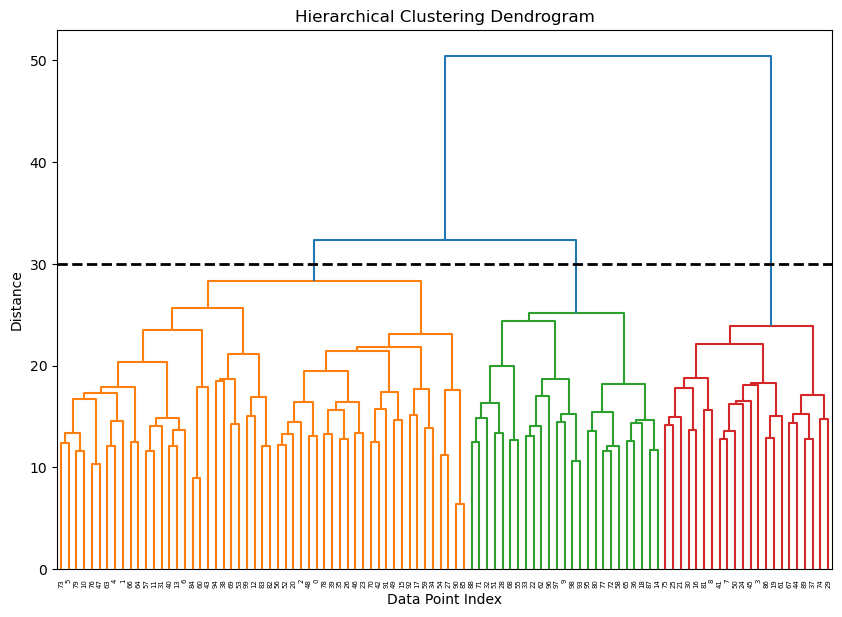

In [245]:
# clustering
from scipy.cluster.hierarchy import dendrogram, linkage
# Perform hierarchical clustering using Ward's method and Euclidean distance
linked = linkage(clustering_data, method='ward', metric='euclidean')
# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linked,
           orientation='top',
           #labels=range(len(data)), # Optional: label leaf nodes
           distance_sort='descending',
           show_leaf_counts=True,
           color_threshold=30)
plt.title('Hierarchical Clustering Dendrogram')
plt.axhline(30, color='k', linestyle='--', linewidth=2)
plt.xlabel('Data Point Index')
plt.ylabel('Distance')
plt.show()

In [246]:
from scipy.cluster.hierarchy import fcluster
max_d = 40
clusters = fcluster(linked, max_d, criterion='distance')
clusters

ids = clustering_data.index

df_clustering_results = pd.DataFrame(columns=["session", "clusters"])



In [247]:
df_clustering_results["session"] = ids
df_clustering_results["clusters"] = clusters

df_clustering_results

,session,clusters
0,1031,2
1,1097,2
2,1170,2
3,1250,1
4,1313,2
...,...,...
95,3233,2
96,3247,2
97,3248,2
98,3250,2


In [248]:
df_meta = df_meta.drop_duplicates(subset="session")[["session", "session_mass_kg", "session_height_m", "age_yrs", "playing_level","pitch_speed_mph"]]
df_meta

,session,session_mass_kg,session_height_m,age_yrs,playing_level,pitch_speed_mph
0,1031,110.6784,1.9304,21.40,college,90.4
2,1097,101.1528,1.9304,19.41,college,77.6
5,1170,82.1016,1.9304,20.52,college,80.9
7,1250,78.4728,1.7526,21.49,college,88.1
9,1313,84.3696,1.8288,19.02,college,85.8
...,...,...,...,...,...,...
387,3233,80.7408,1.9050,18.90,college,85.7
392,3247,87.9984,1.7780,20.68,college,83.1
397,3248,81.1944,1.8288,24.02,college,89.8
402,3250,83.4624,1.8796,23.13,milb,90.0


In [ ]:
df_clustering_results["session"] = df_clustering_results["session"].astype("int")
df_merged = pd.merge(df_clustering_results, df_meta, left_on="session", right_on="session")

In [250]:
elbow_varus_moment = df_point.groupby("session", as_index=False)["elbow_varus_moment"].mean()
df_merged = pd.merge(df_merged, elbow_varus_moment, left_on="session", right_on="session")

In [251]:
df_merged = df_merged[df_merged["playing_level"] == "college"]

In [259]:
df_merged.groupby("clusters")["pitch_speed_mph"].mean()

clusters
1    83.833333
2    85.050000
Name: pitch_speed_mph, dtype: float64

In [253]:
df_merged.groupby("clusters")["elbow_varus_moment"].mean()

clusters
1    111.009862
2    109.114280
Name: elbow_varus_moment, dtype: float64

/tmp/ipykernel_2736/4236894915.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(x=df_merged["clusters"],


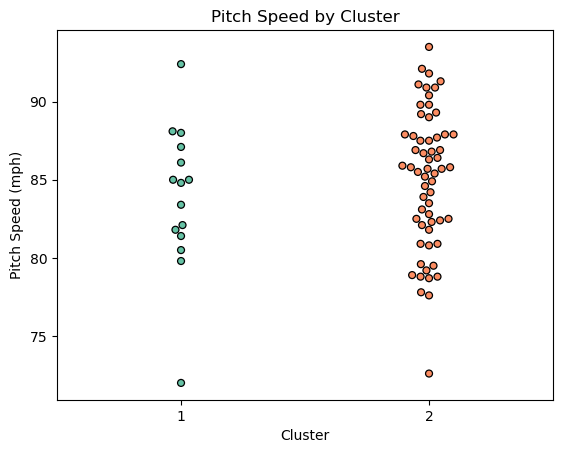

In [254]:
# plot by cluster
import seaborn as sns
fig, ax = plt.subplots()

sns.swarmplot(x=df_merged["clusters"],
              y=df_merged["pitch_speed_mph"],
              ax=ax,
              palette='Set2', # Point color
              edgecolor='black', # Edge color
              linewidth=0.9, # Edge size
                )

plt.xlabel('Cluster')
plt.ylabel('Pitch Speed (mph)')
plt.title("Pitch Speed by Cluster")
plt.show()

/tmp/ipykernel_2736/3951241293.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(x=df_merged["clusters"],


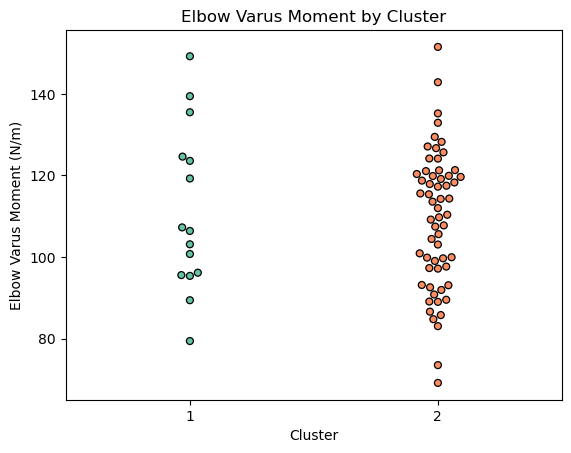

In [255]:
# plot by cluster
import seaborn as sns
fig, ax = plt.subplots()

sns.swarmplot(x=df_merged["clusters"],
              y=df_merged["elbow_varus_moment"],
              ax=ax,
              palette='Set2', # Point color
              edgecolor='black', # Edge color
              linewidth=0.9, # Edge size
                )

plt.xlabel('Cluster')
plt.ylabel('Elbow Varus Moment (N/m)')
plt.title("Elbow Varus Moment by Cluster")
plt.show()

In [256]:
import statsmodels.formula.api as smf
model = smf.mixedlm("elbow_varus_moment ~ C(clusters)", df_merged, groups=df_merged["session"])
result = model.fit()

# Print the model summary, which includes fixed effects estimates and p-values
print(result.summary())

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: elbow_varus_moment
No. Observations: 75      Method:             REML              
No. Groups:       75      Scale:              152.3300          
Min. group size:  1       Log-Likelihood:     -315.7344         
Max. group size:  1       Converged:          Yes               
Mean group size:  1.0                                           
----------------------------------------------------------------
                    Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
----------------------------------------------------------------
Intercept          111.010    1.421 78.144 0.000 108.226 113.794
C(clusters)[T.2]    -1.896    0.718 -2.640 0.008  -3.303  -0.488
Group Var          152.330                                      



/home/yyanagita/anaconda3/envs/Dissertation/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [257]:
import statsmodels.formula.api as smf
model = smf.mixedlm("pitch_speed_mph ~ C(clusters)", df_merged, groups=df_merged["session"])
result = model.fit()

# Print the model summary, which includes fixed effects estimates and p-values
print(result.summary())

            Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: pitch_speed_mph
No. Observations: 75      Method:             REML           
No. Groups:       75      Scale:              9.8730         
Min. group size:  1       Log-Likelihood:     -215.8616      
Max. group size:  1       Converged:          Yes            
Mean group size:  1.0                                        
-------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept          83.833    0.885 94.774 0.000 82.100 85.567
C(clusters)[T.2]    1.217    0.519  2.343 0.019  0.199  2.234
Group Var           9.873                                    



/home/yyanagita/anaconda3/envs/Dissertation/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [258]:
model = smf.mixedlm("pitch_speed_mph ~ elbow_varus_moment * C(clusters)", df_merged, groups=df_merged["clusters"])
result = model.fit()

# Print the model summary, which includes fixed effects estimates and p-values
print(result.summary())

                       Mixed Linear Model Regression Results
Model:                     MixedLM        Dependent Variable:        pitch_speed_mph
No. Observations:          75             Method:                    REML           
No. Groups:                2              Scale:                     16.7392        
Min. group size:           15             Log-Likelihood:            -213.3540      
Max. group size:           60             Converged:                 Yes            
Mean group size:           37.5                                                     
------------------------------------------------------------------------------------
                                    Coef.     Std.Err.     z    P>|z|  [0.025 0.975]
------------------------------------------------------------------------------------
Intercept                           70.848         7.374  9.608 0.000  56.395 85.301
C(clusters)[T.2]                     2.974         9.133  0.326 0.745 -14.926 20.874
elbo

<Axes: xlabel='elbow_varus_moment', ylabel='pitch_speed_mph'>

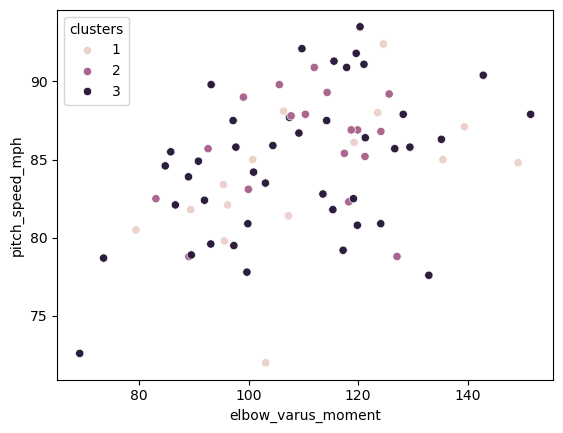

In [243]:
sns.scatterplot(df_merged, x="elbow_varus_moment",
                y="pitch_speed_mph", hue="clusters")

### A signle pitcher example

In [ ]:
id = unique_sessions[0]
print(f"processing: {id}")
# instanciate an empty list that will contain invalid trials
del_df = []
clustering_data = pd.DataFrame()

id = id.astype("str")
# data by a pithcer
df_by_id = df_joint_velocity[df_joint_velocity["session_pitch"].str.contains(id)]
df_by_id.isna().sum()

# get unique session 
unique_sessions_by_pitcher = df_by_id["session_pitch"].unique()
print(f"unique sessions: {unique_sessions_by_pitcher}")

# create col names by nubmer of pitches
n_pitchs = len(unique_sessions_by_pitcher)
print(f'Number of trials: {n_pitchs}')

# create empty dataframes basebd on number of trials for later averaging them
dfs = [pd.DataFrame() for _ in range(n_pitchs)]
print(f"number of trials: {n_pitchs}")
print(f"data length: {len(dfs)}")

# iterate through trials within a sigle pitcher and get average of trials
for session, n_pitch in zip(unique_sessions_by_pitcher, range(n_pitchs)):

    print(f"processing: {session}, trial: {n_pitch + 1}")

    dfs[n_pitch] = segment_resample(df_by_id, session, n_pitch, del_df) # this returns dataframe with 101 rows

    # when the final trial is done 
    if n_pitch +1 == n_pitchs:

        # delete empty dfs

        # Sort indices in reverse order to avoid index shifting issues
        del_df.sort(reverse=True)

        if len(del_df) > 0:
            for i in del_df:
                del dfs[i]

        # Compute the average across them
        corr_data = sum(dfs) / len(dfs)

        corr_matrix = corr_data.corr()

        upper_triangle = np.triu(corr_matrix, k=1)
        unique_corr = upper_triangle[upper_triangle != 0]
        print(f"a feature vector shape: {unique_corr.shape}")
        df = pd.DataFrame(unique_corr)
        clustering_data = pd.concat([clustering_data, df])



processing: 1031
unique sessions: ['1031_2' '1031_3']
Number of trials: 2
number of trials: 2
data length: 2
processing: 1031_2, trial: 1


TypeError: segment_resample() missing 1 required positional argument: 'del_df'

""


In [ ]:
upper_triangle = np.triu(corr_matrix, k=1)
unique_corr = upper_triangle[upper_triangle != 0]
print(f"a feature vector shape: {unique_corr.shape}")
df = pd.DataFrame(unique_corr)
df1 = pd.DataFrame()
df1 = pd.concat([df1, df])


a feature vector shape: (741,)


,0
0,-0.024288
1,-0.082022
2,-0.589985
3,0.689523
4,-0.625215
...,...
736,0.490174
737,-0.494131
738,0.316968
739,0.530280


In [16]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

<Axes: >

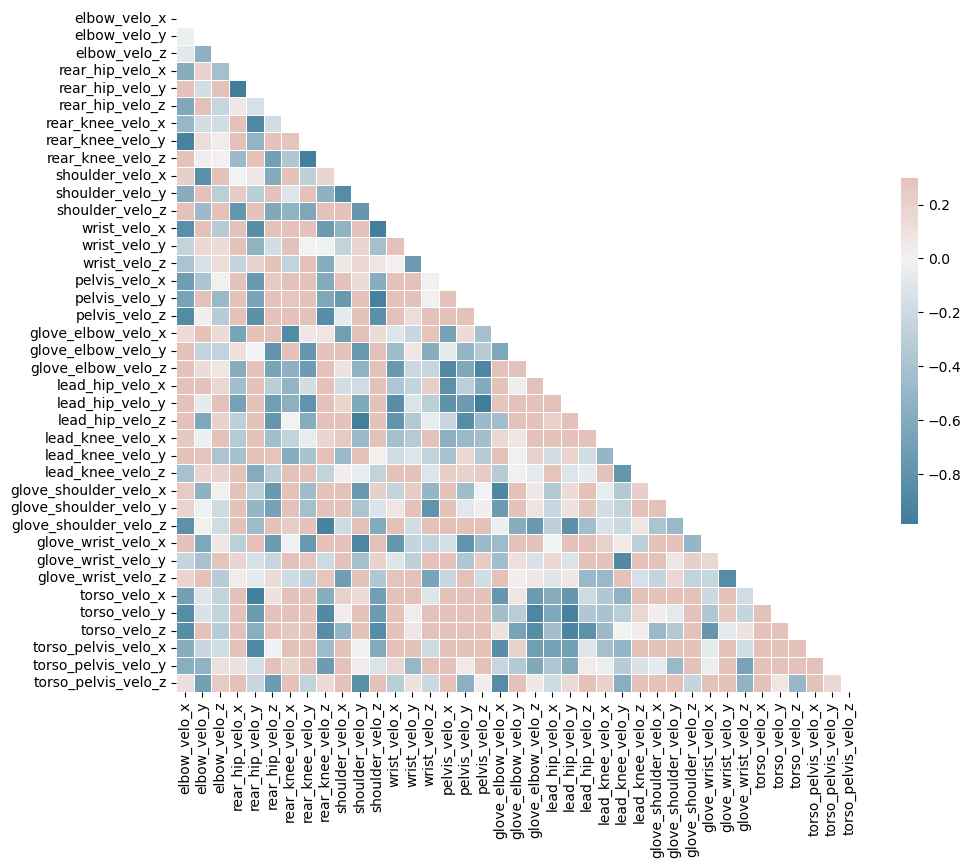

In [17]:
# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})